In [1]:
import gdal
import h5py
import numpy as np
from math import floor
import os
import matplotlib.pyplot as plt
import IPython

read in data

In [2]:
dtm_filepath='/Users/kdw223/Desktop/NEON_day3/data/extra_uncert/SERC_DTM.tif'
gps_val_filepath='/Users/kdw223/Desktop/NEON_day3/data/extra_uncert/SERC_GPS_validation.csv'

Load in functions to process data

In [3]:
def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)

        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==int(metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
        return array, metadata

    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')

In [4]:
dtm_array, dtm_array_metadata = raster2array(dtm_filepath)

In [5]:
val_data=np.genfromtxt(gps_val_filepath, delimiter=",")

In [6]:
elev_error=np.zeros(len(val_data[:,0]))
Lidar_elev=elev_error.copy()

In [7]:
for gps_point_counter in range(0, len(val_data[:,0])-1):
    validation_x_coord=val_data[gps_point_counter, 2]
    validation_y_coord=val_data[gps_point_counter, 1]
    
    index_y=floor(validation_x_coord - dtm_array_metadata['ext_dict']['xMin'])
    index_x=floor(dtm_array_metadata['ext_dict']['yMax']- validation_y_coord)
    
    Lidar_elev[gps_point_counter]=dtm_array[index_x, index_y]
    elev_error[gps_point_counter]=val_data[gps_point_counter, 3]-Lidar_elev[gps_point_counter]
    

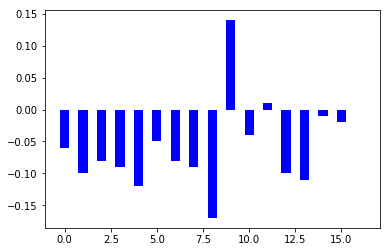

In [8]:
fig, ax=plt.subplots()
elevation_errors=ax.bar(range(len(elev_error)), elev_error, 0.5, color='b')

In [9]:
mean_error=np.mean(elev_error)
mean_error

-0.057058050772723294

In [10]:
std_error=np.std(elev_error)
std_error

0.06728056156082494

In [11]:
%whos

Variable             Type                          Data/Info
------------------------------------------------------------
IPython              module                        <module 'IPython' from '/<...>ges/IPython/__init__.py'>
Lidar_elev           ndarray                       17: 17 elems, type `float64`, 136 bytes
ax                   AxesSubplot                   AxesSubplot(0.125,0.125;0.775x0.755)
dtm_array            ndarray                       14982x11197: 167753454 elems, type `float64`, 1342027632 bytes (1279.8572845458984 Mb)
dtm_array_metadata   dict                          n=13
dtm_filepath         str                           /Users/kdw223/Desktop/NEO<...>extra_uncert/SERC_DTM.tif
elev_error           ndarray                       17: 17 elems, type `float64`, 136 bytes
elevation_errors     BarContainer                  <BarContainer object of 17 artists>
fig                  Figure                        Figure(432x288)
floor                builtin_function_or_metho

In [12]:
print(IPython.sys_info())

{'commit_hash': '7f10f7bb3',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/Users/kdw223/anaconda3/lib/python3.6/site-packages/IPython',
 'ipython_version': '6.4.0',
 'os_name': 'posix',
 'platform': 'Darwin-15.6.0-x86_64-i386-64bit',
 'sys_executable': '/Users/kdw223/anaconda3/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) \n'
                '[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'}
